#  Email  Action Item Detection

Training a machine learning model for text classifiction – specifically, training an email action item detector on a portion of the Enron Email Dataset.



In [1]:
import csv
import time
from collections import Counter

import numpy as np
import torch
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torchtext.vocab import Vocab
from torchtext.data.utils import get_tokenizer
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import test  # Load tests 

## The Enron Email Dataset

The Enron email dataset contains approximately 500,000 emails generated by employees of the Enron Corporation. It was obtained by the Federal Energy Regulatory Commission during its investigation of Enron's collapse. Each email is labeled with several categories (e.g. legal advice, humor, internal company policy, etc.). 

The detection of Action items involves identifying sentences in an email that may require action on the part of the recipient.



In [2]:
with open('./data/action-items.csv') as f:
    for _ in range(10): # first 10 lines
        print(f.readline())

label,sentences

0,

0,Traveling to have a business meeting takes the fun out of the trip.

0,Especially if you have to prepare a presentation.

0,I would suggest holding the business plan meetings here then take a trip without any formal business meetings.

0,I would even try and get some honest opinions on whether a trip is even desired or necessary.

0,"As far as the business meetings, I think it would be more productive to try and stimulate discussions across the different groups about what is working and what is not."

0,Too often the presenter speaks and the others are quiet just waiting for their turn.

0,The meetings might be better if held in a round table discussion format.

0,My suggestion for where to go is Austin.



In the data, each row represents a sentence in our dataset, with the first column as the label (0 for not action item, 1 for action item), and with the second column as the sentence text.

# Parsing the Raw Data


In [3]:
import pandas as pd
import re
import copy
def parse_file(file_path):
    file_data = pd.read_csv(file_path, engine='python')
    file_data.rename(columns={"label": "label", "sentences": "text"},inplace=True)
    #file_data = file_data.dropna()
    file_data = file_data.replace({np.nan: 'None'})
    file_data.replace({0: -1}, inplace=True)
    file_data_ = copy.deepcopy(file_data)
    for i in range(file_data_.shape[0]):
        file_data_['text'][i] = re.sub('(?<!^)"(?!,")(?<!,")(?!$)', '', file_data_['text'][i], flags=re.M)
    data_array = list(file_data_.T.to_dict().values())
    return data_array

In [4]:
# Parse the file and run tests!
examples = parse_file("./data/action-items.csv")
test.data_parsing(examples=examples)

<ipython-input-3-3f91ee326938>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file_data_['text'][i] = re.sub('(?<!^)"(?!,")(?<!,")(?!$)', '', file_data_['text'][i], flags=re.M)


Finished running tests: Data Parsing - 5/5 passed


In [5]:
# Extract Email containing questions for analysis.....
def extract_questions(df):
    Question, non_question = {},{}
    count,count2 = 0,0
    for i in range(df.shape[0]):
        if df['text'][i].endswith("?"):
            Question[df['label'][i]]=[df['text'][i]]
            if df['label'][i] == 1:
                count +=1
            else:
                count2 +=1 
        else:
            non_question[df['label'][i]]=[df['text'][i]]
    return Question,count,count2


examples_df = pd.DataFrame(examples)
b,cnt,cnt2 = extract_questions(examples_df)
print(f'There are {cnt} action items which are questions')
print(f'There are {cnt2} non action items which are questions')

There are 640 action items which are questions
There are 4393 non action items which are questions


- since there are more questions labelled as non-action items (4393); than there are action items (640).
- Hence, In this dataset, questions are usually not considered as action items.
- Examples of action items include:
    - I think my folks are ready  to start building.
    - We are taking the  kids to Disney for their birthdays.
    - I know challenging times are ahead, please let me know what I can do to help facilitate this review process.

**What percent of examples are action items? What percent are not?**

In [6]:
examples_df['label'].value_counts()/examples_df.shape[0]

-1    0.872675
 1    0.127325
Name: label, dtype: float64

- Approximately 87.3% of the emails in the dataset is labelled as non-action items.
- Whereas 12.7% of the emails were labelled as action items.

# Training/Testing Data Split



In [7]:
def train_test_split(all_examples, train_test_split=.8):
    data = all_examples
    shuffled_indicies=np.random.RandomState(seed=42).permutation(len(data))
    train_set_size= int(len(data)*train_test_split)
    train_indicies=shuffled_indicies[:train_set_size]
    test_indicies=shuffled_indicies[train_set_size:]
    return np.array(data)[train_indicies],np.array(data)[test_indicies]

 

In [8]:
# Split the data into the train and test sets!
train_examples, test_examples = train_test_split(examples)

# Preprocessing 



## Vocabulary Development


In [9]:
# Reformat our training/test examples
train_iter = [(int(x['label']), x['text']) for x in train_examples]
test_iter = [(int(x['label']), x['text']) for x in test_examples]

# Tokenize training sentences to build vocabulary
tokenizer = get_tokenizer('basic_english')

counter = Counter()
for (label, text) in train_iter:
    counter.update(tokenizer(text))
    
vocab = Vocab(counter, min_freq=10)

In [10]:
print(f"There are {len(vocab.itos)} distinct IDs in the vocabulary.")

There are 6392 distinct IDs in the vocabulary.



## Bag of Words



In [12]:
def bow_vector(text):
    tokenized_words = tokenizer(text)
    vocab_list = vocab.itos#list(vocab.stoi.keys())
    bow_dict = {}
    for i in vocab_list:
        ##set the bag of words dictionary values initially to zero.
        bow_dict[i] = 0
    for j in range(len(tokenized_words)):
        if tokenized_words[j] in vocab_list:
            #update count of words occuring in bag of words dictionary.
            bow_dict[tokenized_words[j]] +=1
        else:
            pass
    return np.array(list(bow_dict.values()))

##test the bow_vector method.
#I am testing to see if the length of the final vector is equal to the number of IDs in the vocabulary.
len(bow_vector('I think my folks are ready to start building.')) == len(vocab.itos)

True

## 3.3: Batching and DataLoader

Grouping the training and test examples into **batches**.
Here we use a **batch size** of 8 meaning that during training our model will take 8 of our Bag-of-Words vectors as input, and produce 8 different label predictions as output.



In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    """Converts raw batch examples into tensors"""
    label_list, text_list = [], []
    
    for (_label, _text) in batch:
         label_list.append(_label)
         
         processed_text = torch.tensor(bow_vector(_text), dtype=torch.float32)  # Create BOW tensor
         processed_text = torch.unsqueeze(processed_text, 0)  # Expand 0th dimension to allow for concatenation later
         text_list.append(processed_text)
    
    # Make target tensor of labels
    label_list = torch.tensor(label_list, dtype=torch.int64)
    
    # Make input tensor of BOW vectors
    text_list = torch.cat(text_list, dim=0)
    
    return label_list.to(device), text_list.to(device)

# Prepare dataloaders
train_dataloader = DataLoader(list(train_iter), batch_size=8, shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(list(test_iter), batch_size=8, shuffle=False, collate_fn=collate_batch)

In [14]:
label, text = next(iter(train_dataloader))
print(f'Shape of input tensors(text) ====> {text.shape}')
print(f'Shape of output tensors(labels) ======> {label.shape}')

Shape of input tensors(text) ====> torch.Size([8, 6392])
Shape of output tensors(labels) ======> torch.Size([8])


- Shape of each input tensors(text) is (8, 6392)
- Shape of each output tensors(labels) is (8)

# Simple Neural Network

In [15]:
class ActionItemModel(torch.nn.Module):
    def __init__(self, vocab_size, hidden_dim):
        super(ActionItemModel, self).__init__()
        self.hidden = torch.nn.Linear(vocab_size, hidden_dim)
        self.output = torch.nn.Linear(hidden_dim,1)

    def forward(self, bow_vectors):
        hidden = torch.tanh(self.hidden(bow_vectors))
        output = torch.tanh(self.output(hidden))
        final_output = output.squeeze()
        return final_output

Now we'll create an instance of our model. We'll start by using a hidden dimension of 300.

In [16]:
vocab_size = len(vocab)
hidden_dim = 300
model = ActionItemModel(vocab_size, hidden_dim).to(device)

# Training

In [17]:
def train(dataloader):
    # Put the model in training mode
    model.train()
    
    # Keep track of metrics
    losses = []
    accs = []
    total_acc, total_loss, total_count = 0, 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (label, text) in tqdm(enumerate(dataloader), total=len(dataloader)):
        optimizer.zero_grad()  # Reset the optimizer
        
        predicted_label = model(text)  # Predict the labels
        
        loss = criterion(predicted_label, label.float())  # Calculate loss
        
        # Update the model weights
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        
        # Keep track of metrics
        total_acc += (predicted_label * label > 0).sum().item()
        total_loss += loss.sum().item()
        total_count += label.size(0)
        
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| train accuracy {:8.3f} | loss {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count, total_loss/total_count))
            
            losses.append(total_loss/total_count)
            accs.append(total_acc/total_count)
            
            total_acc, total_loss, total_count = 0, 0, 0
            start_time = time.time()
    return losses, accs

In [18]:
def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text) in enumerate(dataloader):
            predicted_label = model(text)
            loss = criterion(predicted_label, label)
            
            total_acc += (predicted_label * label > 0).sum().item()
            total_count += label.size(0)

    return total_acc/total_count

In [19]:
# Hyperparameters
EPOCHS = 10 # epoch
LR = 5  # learning rate

criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None

train_dataset = list(train_iter)
test_dataset = list(test_iter)

all_losses = []
all_accuracies = []

for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()

    losses, accs = train(train_dataloader)
    
    all_losses.extend(losses)
    all_accuracies.extend(accs)
    
    accu_val = evaluate(test_dataloader)
    if total_accu is not None and total_accu > accu_val:
      scheduler.step()
    else:
       total_accu = accu_val
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'test accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val))
    print('-' * 59)

  0%|          | 0/4625 [00:00<?, ?it/s]

| epoch   1 |   500/ 4625 batches | train accuracy    0.869 | loss    0.055
| epoch   1 |  1000/ 4625 batches | train accuracy    0.885 | loss    0.049
| epoch   1 |  1500/ 4625 batches | train accuracy    0.890 | loss    0.046
| epoch   1 |  2000/ 4625 batches | train accuracy    0.894 | loss    0.046
| epoch   1 |  2500/ 4625 batches | train accuracy    0.884 | loss    0.050
| epoch   1 |  3000/ 4625 batches | train accuracy    0.895 | loss    0.046
| epoch   1 |  3500/ 4625 batches | train accuracy    0.901 | loss    0.046
| epoch   1 |  4000/ 4625 batches | train accuracy    0.899 | loss    0.045
| epoch   1 |  4500/ 4625 batches | train accuracy    0.899 | loss    0.046
-----------------------------------------------------------
| end of epoch   1 | time: 316.54s | test accuracy    0.894 
-----------------------------------------------------------


c:\users\alex\summer_interns_conv_ai_path\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


  0%|          | 0/4625 [00:00<?, ?it/s]

| epoch   2 |   500/ 4625 batches | train accuracy    0.916 | loss    0.037
| epoch   2 |  1000/ 4625 batches | train accuracy    0.911 | loss    0.041
| epoch   2 |  1500/ 4625 batches | train accuracy    0.909 | loss    0.042
| epoch   2 |  2000/ 4625 batches | train accuracy    0.918 | loss    0.037
| epoch   2 |  2500/ 4625 batches | train accuracy    0.897 | loss    0.046
| epoch   2 |  3000/ 4625 batches | train accuracy    0.915 | loss    0.039
| epoch   2 |  3500/ 4625 batches | train accuracy    0.915 | loss    0.039
| epoch   2 |  4000/ 4625 batches | train accuracy    0.894 | loss    0.047
| epoch   2 |  4500/ 4625 batches | train accuracy    0.923 | loss    0.036
-----------------------------------------------------------
| end of epoch   2 | time: 322.47s | test accuracy    0.910 
-----------------------------------------------------------


  0%|          | 0/4625 [00:00<?, ?it/s]

| epoch   3 |   500/ 4625 batches | train accuracy    0.917 | loss    0.039
| epoch   3 |  1000/ 4625 batches | train accuracy    0.920 | loss    0.037
| epoch   3 |  1500/ 4625 batches | train accuracy    0.919 | loss    0.037
| epoch   3 |  2000/ 4625 batches | train accuracy    0.925 | loss    0.035
| epoch   3 |  2500/ 4625 batches | train accuracy    0.921 | loss    0.037
| epoch   3 |  3000/ 4625 batches | train accuracy    0.916 | loss    0.038
| epoch   3 |  3500/ 4625 batches | train accuracy    0.923 | loss    0.036
| epoch   3 |  4000/ 4625 batches | train accuracy    0.918 | loss    0.037
| epoch   3 |  4500/ 4625 batches | train accuracy    0.920 | loss    0.037
-----------------------------------------------------------
| end of epoch   3 | time: 345.80s | test accuracy    0.920 
-----------------------------------------------------------


  0%|          | 0/4625 [00:00<?, ?it/s]

| epoch   4 |   500/ 4625 batches | train accuracy    0.930 | loss    0.033
| epoch   4 |  1000/ 4625 batches | train accuracy    0.922 | loss    0.036
| epoch   4 |  1500/ 4625 batches | train accuracy    0.928 | loss    0.033
| epoch   4 |  2000/ 4625 batches | train accuracy    0.926 | loss    0.035
| epoch   4 |  2500/ 4625 batches | train accuracy    0.929 | loss    0.034
| epoch   4 |  3000/ 4625 batches | train accuracy    0.923 | loss    0.036
| epoch   4 |  3500/ 4625 batches | train accuracy    0.928 | loss    0.034
| epoch   4 |  4000/ 4625 batches | train accuracy    0.926 | loss    0.036
| epoch   4 |  4500/ 4625 batches | train accuracy    0.928 | loss    0.033
-----------------------------------------------------------
| end of epoch   4 | time: 324.77s | test accuracy    0.919 
-----------------------------------------------------------


  0%|          | 0/4625 [00:00<?, ?it/s]

| epoch   5 |   500/ 4625 batches | train accuracy    0.937 | loss    0.030
| epoch   5 |  1000/ 4625 batches | train accuracy    0.932 | loss    0.032
| epoch   5 |  1500/ 4625 batches | train accuracy    0.942 | loss    0.028
| epoch   5 |  2000/ 4625 batches | train accuracy    0.934 | loss    0.031
| epoch   5 |  2500/ 4625 batches | train accuracy    0.938 | loss    0.030
| epoch   5 |  3000/ 4625 batches | train accuracy    0.934 | loss    0.032
| epoch   5 |  3500/ 4625 batches | train accuracy    0.938 | loss    0.029
| epoch   5 |  4000/ 4625 batches | train accuracy    0.933 | loss    0.032
| epoch   5 |  4500/ 4625 batches | train accuracy    0.949 | loss    0.024
-----------------------------------------------------------
| end of epoch   5 | time: 398.37s | test accuracy    0.927 
-----------------------------------------------------------


  0%|          | 0/4625 [00:00<?, ?it/s]

| epoch   6 |   500/ 4625 batches | train accuracy    0.942 | loss    0.027
| epoch   6 |  1000/ 4625 batches | train accuracy    0.942 | loss    0.028
| epoch   6 |  1500/ 4625 batches | train accuracy    0.942 | loss    0.028
| epoch   6 |  2000/ 4625 batches | train accuracy    0.938 | loss    0.030
| epoch   6 |  2500/ 4625 batches | train accuracy    0.939 | loss    0.029
| epoch   6 |  3000/ 4625 batches | train accuracy    0.941 | loss    0.028
| epoch   6 |  3500/ 4625 batches | train accuracy    0.939 | loss    0.029
| epoch   6 |  4000/ 4625 batches | train accuracy    0.940 | loss    0.028
| epoch   6 |  4500/ 4625 batches | train accuracy    0.939 | loss    0.029
-----------------------------------------------------------
| end of epoch   6 | time: 348.57s | test accuracy    0.927 
-----------------------------------------------------------


  0%|          | 0/4625 [00:00<?, ?it/s]

| epoch   7 |   500/ 4625 batches | train accuracy    0.940 | loss    0.029
| epoch   7 |  1000/ 4625 batches | train accuracy    0.943 | loss    0.028
| epoch   7 |  1500/ 4625 batches | train accuracy    0.941 | loss    0.028
| epoch   7 |  2000/ 4625 batches | train accuracy    0.939 | loss    0.029
| epoch   7 |  2500/ 4625 batches | train accuracy    0.941 | loss    0.029
| epoch   7 |  3000/ 4625 batches | train accuracy    0.939 | loss    0.030
| epoch   7 |  3500/ 4625 batches | train accuracy    0.943 | loss    0.027
| epoch   7 |  4000/ 4625 batches | train accuracy    0.948 | loss    0.025
| epoch   7 |  4500/ 4625 batches | train accuracy    0.941 | loss    0.029
-----------------------------------------------------------
| end of epoch   7 | time: 326.71s | test accuracy    0.929 
-----------------------------------------------------------


  0%|          | 0/4625 [00:00<?, ?it/s]

| epoch   8 |   500/ 4625 batches | train accuracy    0.940 | loss    0.029
| epoch   8 |  1000/ 4625 batches | train accuracy    0.947 | loss    0.026
| epoch   8 |  1500/ 4625 batches | train accuracy    0.943 | loss    0.028
| epoch   8 |  2000/ 4625 batches | train accuracy    0.939 | loss    0.029
| epoch   8 |  2500/ 4625 batches | train accuracy    0.943 | loss    0.028
| epoch   8 |  3000/ 4625 batches | train accuracy    0.943 | loss    0.028
| epoch   8 |  3500/ 4625 batches | train accuracy    0.946 | loss    0.026
| epoch   8 |  4000/ 4625 batches | train accuracy    0.942 | loss    0.029
| epoch   8 |  4500/ 4625 batches | train accuracy    0.947 | loss    0.026
-----------------------------------------------------------
| end of epoch   8 | time: 383.23s | test accuracy    0.929 
-----------------------------------------------------------


  0%|          | 0/4625 [00:00<?, ?it/s]

| epoch   9 |   500/ 4625 batches | train accuracy    0.942 | loss    0.028
| epoch   9 |  1000/ 4625 batches | train accuracy    0.939 | loss    0.030
| epoch   9 |  1500/ 4625 batches | train accuracy    0.945 | loss    0.026
| epoch   9 |  2000/ 4625 batches | train accuracy    0.943 | loss    0.028
| epoch   9 |  2500/ 4625 batches | train accuracy    0.939 | loss    0.029
| epoch   9 |  3000/ 4625 batches | train accuracy    0.947 | loss    0.026
| epoch   9 |  3500/ 4625 batches | train accuracy    0.949 | loss    0.025
| epoch   9 |  4000/ 4625 batches | train accuracy    0.942 | loss    0.028
| epoch   9 |  4500/ 4625 batches | train accuracy    0.948 | loss    0.025
-----------------------------------------------------------
| end of epoch   9 | time: 410.07s | test accuracy    0.930 
-----------------------------------------------------------


  0%|          | 0/4625 [00:00<?, ?it/s]

| epoch  10 |   500/ 4625 batches | train accuracy    0.940 | loss    0.029
| epoch  10 |  1000/ 4625 batches | train accuracy    0.946 | loss    0.026
| epoch  10 |  1500/ 4625 batches | train accuracy    0.944 | loss    0.028
| epoch  10 |  2000/ 4625 batches | train accuracy    0.946 | loss    0.027
| epoch  10 |  2500/ 4625 batches | train accuracy    0.947 | loss    0.026
| epoch  10 |  3000/ 4625 batches | train accuracy    0.947 | loss    0.026
| epoch  10 |  3500/ 4625 batches | train accuracy    0.950 | loss    0.025
| epoch  10 |  4000/ 4625 batches | train accuracy    0.947 | loss    0.026
| epoch  10 |  4500/ 4625 batches | train accuracy    0.942 | loss    0.028
-----------------------------------------------------------
| end of epoch  10 | time: 427.02s | test accuracy    0.931 
-----------------------------------------------------------


In [20]:
evaluate(test_dataloader)

0.9306952102930046

- The final test accuracy of the model is 93.07%


-  Accuracy is not a good measure of this model's performance. This is because the dataset is imbalanced.
    - There are 4393 non action items and 640 action items. 
- The only advantage of using accuracy as an evaluation metric for our problem is that we are able to identify the percentage of correctly classified action or non-action items.
   

**Loss change over time**

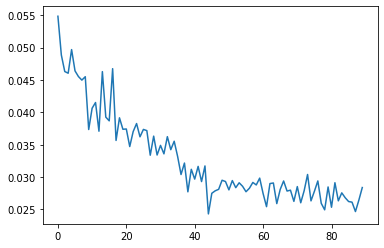

In [21]:
plt.plot(all_losses);

**Accuracy change over time**

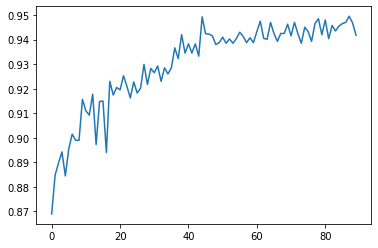

In [22]:
plt.plot(all_accuracies);

- Training and Test set accuracies are  within +/- 0.2 differences. Very Similiar!!
- No large differences between both accuracies, No overfitting in each epoch

# Better Evaluation

When evaluating our model on the action item detection task, accuracy doesn't tell the whole picture. Instead, we may want to answer the questions: How many of the sentences that our model flags are actually action items (**precision**), and what percent of all action items will it sucessfully detect (**recall**)?

In [23]:
def eval_with_pr(dataloader):
    model.eval()
    total_acc,total_tp, total_count = 0,0,0
    total_tn,total_fp,total_fn = 0,0,0

    with torch.no_grad():
        for idx, (label, text) in enumerate(dataloader):
            predicted_label = model(text)
            loss = criterion(predicted_label, label)
            print(predicted_label,label)
            total_acc += (predicted_label * label > 0).sum().item()
            total_tp += (predicted_label + label > 0).sum().item()
            total_tn += (predicted_label + label < 0).sum().item()
            total_fn += ((predicted_label <0) * (label>0)).sum().item()
            total_fp += ((predicted_label > 0) * (label<0)).sum().item()
            print(total_tn,total_fp,total_fn,total_tp)
            total_count += label.size(0)
    acc = total_acc/total_count
    recall = total_tp/(total_tp + total_fn)
    precision = total_tp/(total_tp + total_fp)
    print(f'Recall: {recall}, Precision {precision},Accuracy{acc}')
    
    return acc,recall,precision

In [24]:
eval_with_pr(test_dataloader)

tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000]) tensor([-1, -1, -1, -1, -1, -1, -1, -1])
8 0 0 0
tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000]) tensor([-1, -1, -1, -1, -1, -1, -1, -1])
16 0 0 0
tensor([-1.0000, -1.0000, -1.0000, -1.0000,  1.0000, -0.9998, -1.0000, -1.0000]) tensor([-1, -1, -1, -1,  1, -1, -1, -1])
23 0 0 1
tensor([-1., -1., -1., -1., -1., -1., -1., -1.]) tensor([-1, -1, -1, -1, -1, -1, -1, -1])
31 0 0 1
tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.1654, -1.0000, -1.0000]) tensor([-1, -1, -1, -1, -1, -1, -1, -1])
39 0 0 1
tensor([-1., -1., -1., -1., -1., -1., -1., -1.]) tensor([-1, -1, -1,  1, -1, -1, -1, -1])
46 0 1 1
tensor([ 0.8193, -1.0000, -1.0000, -1.0000, -1.0000,  1.0000, -1.0000, -1.0000]) tensor([ 1, -1, -1, -1, -1,  1, -1, -1])
52 0 1 3
tensor([-1.0000, -0.9997, -1.0000, -1.0000,  1.0000, -1.0000, -1.0000,  1.0000]) tensor([ 1, -1, -1, -1,  1,  1, -1,  1])
56 0 3 5
tensor([-1.0000, 

tensor([-1.0000,  0.8711,  0.9999,  0.9771, -1.0000, -1.0000, -1.0000, -1.0000]) tensor([-1,  1,  1,  1, -1, -1, -1, -1])
468 4 27 44
tensor([ 0.8990, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000]) tensor([ 1, -1, -1, -1, -1, -1, -1, -1])
475 4 27 45
tensor([-1.0000,  0.9996, -1.0000,  0.9999, -0.9940,  1.0000, -1.0000, -1.0000]) tensor([-1,  1, -1,  1, -1,  1, -1, -1])
480 4 27 48
tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000]) tensor([-1, -1, -1, -1, -1, -1, -1, -1])
488 4 27 48
tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000]) tensor([-1, -1, -1, -1, -1, -1, -1, -1])
496 4 27 48
tensor([-1.0000, -1.0000,  1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000]) tensor([-1, -1,  1, -1, -1, -1, -1, -1])
503 4 27 49
tensor([-1.0000, -1.0000, -0.9996, -1.0000, -1.0000,  0.9999, -0.9999, -1.0000]) tensor([-1, -1,  1, -1, -1,  1, -1, -1])
509 4 28 51
tensor([ 1.0000, -1.0000, -1.0000, -0.9858, -1.0000, -0.9996, 

tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000]) tensor([-1, -1, -1, -1, -1,  1, -1, -1])
935 13 57 80
tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000]) tensor([-1, -1, -1, -1,  1, -1, -1, -1])
942 13 58 80
tensor([ 0.4448, -1.0000, -1.0000, -1.0000, -0.9478, -1.0000, -1.0000, -1.0000]) tensor([-1, -1, -1, -1, -1, -1, -1, -1])
950 14 58 80
tensor([-1.0000, -1.0000, -1.0000, -0.2783, -1.0000, -1.0000, -1.0000, -0.9998]) tensor([-1, -1, -1, -1, -1, -1, -1, -1])
958 14 58 80
tensor([-1.0000,  1.0000,  0.4219, -1.0000, -0.3533, -1.0000, -1.0000, -1.0000]) tensor([-1,  1,  1, -1,  1, -1, -1, -1])
963 14 59 83
tensor([-1.0000,  0.9915, -1.0000, -1.0000, -0.9899, -1.0000,  1.0000, -0.3947]) tensor([-1,  1, -1, -1, -1, -1,  1,  1])
968 14 60 86
tensor([-1.0000, -1.0000, -1.0000, -0.9722, -1.0000, -1.0000, -0.9982, -1.0000]) tensor([-1, -1, -1,  1, -1, -1, -1, -1])
975 14 61 87
tensor([-1.0000,  0.9999, -1.0000, -1.0000, -1.0000, -1

tensor([-1., -1., -1., -1., -1., -1., -1., -1.]) tensor([-1, -1, -1, -1, -1, -1,  1, -1])
1381 21 85 118
tensor([-1.0000, -1.0000, -1.0000, -1.0000, -0.9996,  1.0000, -1.0000, -1.0000]) tensor([-1, -1,  1, -1,  1,  1, -1, -1])
1386 21 87 121
tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000]) tensor([-1, -1, -1, -1, -1,  1, -1, -1])
1393 21 88 122
tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000,  1.0000, -1.0000, -1.0000]) tensor([-1, -1, -1, -1, -1,  1, -1, -1])
1400 21 88 123
tensor([-1.0000, -1.0000, -0.9999, -1.0000, -0.9988, -1.0000, -1.0000, -1.0000]) tensor([-1, -1, -1, -1, -1, -1, -1, -1])
1408 21 88 123
tensor([-1.0000, -1.0000, -1.0000,  0.9778, -1.0000, -1.0000,  1.0000, -1.0000]) tensor([-1, -1, -1,  1,  1, -1,  1, -1])
1413 21 89 125
tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000]) tensor([-1, -1, -1, -1, -1, -1, -1, -1])
1421 21 89 125
tensor([-1.0000,  0.5749, -1.0000,  1.0000, -0.9999, -1.0000, -1.0000, -1

tensor([-1.0000, -1.0000,  1.0000, -1.0000, -1.0000, -1.0000,  0.8333, -1.0000]) tensor([-1,  1,  1, -1, -1, -1, -1, -1])
1811 25 121 176
tensor([-1.0000, -0.8633, -0.9782, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000]) tensor([-1, -1, -1, -1, -1, -1, -1, -1])
1819 25 121 176
tensor([-1.0000, -1.0000, -0.9445, -1.0000, -0.9999, -1.0000, -1.0000, -1.0000]) tensor([-1, -1, -1, -1, -1, -1, -1, -1])
1827 25 121 176
tensor([-1.0000, -0.9974, -1.0000, -1.0000, -1.0000, -0.9968,  0.9990, -1.0000]) tensor([-1, -1, -1, -1, -1, -1,  1, -1])
1834 25 121 177
tensor([ 1.0000, -1.0000, -0.9750, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000]) tensor([ 1, -1, -1, -1, -1, -1, -1, -1])
1841 25 121 178
tensor([-1.0000, -1.0000, -1.0000, -1.0000, -0.9998, -1.0000, -1.0000, -1.0000]) tensor([-1, -1, -1, -1,  1, -1, -1, -1])
1848 25 122 179
tensor([-0.9997, -1.0000, -1.0000, -1.0000, -1.0000,  0.9596, -1.0000, -1.0000]) tensor([-1, -1, -1, -1, -1,  1, -1, -1])
1855 25 122 180
tensor([-1.0000,  1.0000, -1.0000,

tensor([-1.0000, -1.0000,  0.9969, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000]) tensor([-1, -1,  1, -1, -1, -1, -1, -1])
2258 30 140 219
tensor([-0.9999, -1.0000,  1.0000, -1.0000, -1.0000,  0.8280, -1.0000,  1.0000]) tensor([-1, -1,  1, -1, -1,  1, -1,  1])
2263 30 140 222
tensor([-0.9995, -1.0000, -0.9974, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000]) tensor([-1, -1,  1, -1, -1, -1, -1, -1])
2270 30 141 223
tensor([-0.9999, -1.0000, -1.0000, -0.9998, -1.0000, -1.0000, -1.0000, -1.0000]) tensor([-1,  1, -1, -1, -1, -1, -1, -1])
2277 30 142 224
tensor([-1.0000, -1.0000, -1.0000, -1.0000, -0.9996, -1.0000, -1.0000,  1.0000]) tensor([-1, -1, -1, -1, -1, -1, -1,  1])
2284 30 142 225
tensor([-1.0000, -1.0000, -0.9793, -1.0000, -0.9999, -1.0000, -1.0000, -1.0000]) tensor([-1, -1, -1, -1, -1, -1, -1, -1])
2292 30 142 225
tensor([-1.0000, -1.0000, -1.0000,  0.8512, -0.9998, -1.0000, -1.0000, -1.0000]) tensor([-1, -1, -1, -1, -1, -1, -1, -1])
2300 31 142 225
tensor([-1.0000, -1.0000, -1.0000,

tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000]) tensor([-1, -1, -1, -1, -1, -1, -1, -1])
2719 36 161 263
tensor([ 0.9999, -1.0000, -1.0000, -1.0000, -1.0000,  0.9430, -1.0000, -1.0000]) tensor([ 1, -1, -1, -1, -1,  1, -1, -1])
2725 36 161 265
tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000]) tensor([-1, -1, -1, -1, -1, -1, -1, -1])
2733 36 161 265
tensor([-1.0000,  0.9151, -1.0000, -1.0000, -1.0000, -1.0000, -0.9154, -1.0000]) tensor([-1,  1, -1, -1, -1, -1, -1, -1])
2740 36 161 266
tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9997, -1.0000, -1.0000]) tensor([-1, -1, -1, -1, -1, -1, -1, -1])
2748 36 161 266
tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,  0.9969,  1.0000]) tensor([-1, -1, -1, -1, -1, -1,  1,  1])
2754 36 161 268
tensor([-1.0000, -1.0000, -0.9998, -1.0000, -0.9998, -0.9988, -1.0000,  0.9996]) tensor([-1, -1, -1, -1, -1, -1, -1,  1])
2761 36 161 269
tensor([-0.2628,  0.9929, -1.0000,

tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000]) tensor([-1, -1, -1, -1, -1, -1, -1, -1])
3168 42 189 316
tensor([ 1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000]) tensor([ 1, -1, -1, -1, -1, -1, -1, -1])
3175 42 189 317
tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,  0.9996]) tensor([-1, -1, -1, -1, -1, -1, -1,  1])
3182 42 189 318
tensor([-1.0000, -1.0000, -1.0000,  0.9980, -1.0000, -1.0000, -1.0000, -1.0000]) tensor([-1, -1, -1,  1, -1, -1, -1, -1])
3189 42 189 319
tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9963, -1.0000, -1.0000]) tensor([-1, -1, -1, -1, -1, -1, -1, -1])
3197 42 189 319
tensor([-1.0000, -1.0000,  1.0000, -1.0000, -0.9903, -1.0000, -1.0000, -1.0000]) tensor([-1, -1,  1, -1, -1, -1, -1, -1])
3204 42 189 320
tensor([-1.0000, -1.0000, -0.9999, -0.9998, -1.0000, -1.0000, -1.0000, -1.0000]) tensor([-1, -1, -1, -1, -1, -1, -1, -1])
3212 42 189 320
tensor([ 1.0000,  0.8739,  0.9530,

tensor([-1.0000, -0.9997, -1.0000, -1.0000,  1.0000, -1.0000,  0.9994, -1.0000]) tensor([-1, -1, -1, -1,  1, -1, -1, -1])
3607 50 215 358
tensor([-1.0000, -1.0000, -1.0000,  0.9848, -1.0000, -1.0000, -1.0000, -1.0000]) tensor([-1, -1, -1,  1, -1, -1, -1, -1])
3614 50 215 359
tensor([-1.0000, -1.0000, -1.0000,  1.0000, -1.0000, -1.0000, -1.0000, -0.9705]) tensor([-1, -1, -1,  1, -1, -1, -1, -1])
3621 50 215 360
tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,  0.7432, -1.0000]) tensor([-1,  1, -1, -1, -1, -1, -1, -1])
3628 51 216 360
tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000]) tensor([-1, -1, -1, -1, -1, -1, -1, -1])
3636 51 216 360
tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9998, -1.0000, -1.0000]) tensor([-1, -1, -1, -1, -1, -1, -1, -1])
3644 51 216 360
tensor([-1.0000, -1.0000, -1.0000, -0.9999, -0.9989, -1.0000, -1.0000, -0.9990]) tensor([-1, -1, -1, -1, -1, -1, -1, -1])
3652 51 216 360
tensor([-0.9976, -1.0000, -1.0000,

tensor([-1.0000, -1.0000, -1.0000,  0.9523, -1.0000, -1.0000, -1.0000, -1.0000]) tensor([-1, -1, -1,  1, -1, -1, -1, -1])
4048 60 241 397
tensor([-1.0000, -1.0000,  0.4502, -1.0000, -1.0000, -1.0000,  0.7706, -1.0000]) tensor([-1, -1,  1, -1, -1, -1,  1, -1])
4054 60 241 399
tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,  1.0000]) tensor([-1,  1, -1, -1, -1, -1, -1,  1])
4060 60 242 400
tensor([ 1.0000, -1.0000, -1.0000, -0.9986, -1.0000, -1.0000, -1.0000, -1.0000]) tensor([ 1, -1, -1, -1, -1, -1, -1, -1])
4067 60 242 401
tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,  1.0000]) tensor([-1, -1, -1, -1, -1, -1, -1,  1])
4074 60 242 402
tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000]) tensor([-1, -1, -1, -1, -1, -1, -1, -1])
4082 60 242 402
tensor([-1.0000, -1.0000, -1.0000,  1.0000, -1.0000, -0.4728, -1.0000, -1.0000]) tensor([-1, -1, -1,  1, -1, -1, -1, -1])
4089 60 242 403
tensor([-1.0000, -1.0000, -1.0000,

tensor([-1.0000,  1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000]) tensor([-1,  1,  1,  1, -1, -1, -1, -1])
4471 65 284 454
tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000]) tensor([-1, -1, -1, -1,  1, -1, -1, -1])
4478 65 285 454
tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000]) tensor([-1, -1, -1, -1, -1, -1, -1, -1])
4486 65 285 454
tensor([-1.0000, -1.0000,  1.0000,  1.0000, -1.0000, -1.0000, -1.0000,  0.9976]) tensor([-1, -1,  1,  1, -1, -1, -1,  1])
4491 65 285 457
tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9997, -1.0000]) tensor([-1, -1, -1, -1, -1, -1, -1, -1])
4499 65 285 457
tensor([-0.9916, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000]) tensor([-1, -1, -1, -1, -1, -1, -1, -1])
4507 65 285 457
tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000,  0.9996, -1.0000, -1.0000]) tensor([-1, -1, -1, -1, -1,  1, -1, -1])
4514 65 285 458
tensor([-1., -1.,  1., -1., -1., -

tensor([-1.0000,  0.8953, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000]) tensor([-1,  1, -1,  1, -1, -1, -1,  1])
4917 72 316 498
tensor([-1., -1., -1., -1., -1., -1., -1., -1.]) tensor([-1, -1, -1, -1,  1, -1, -1, -1])
4924 72 317 498
tensor([-1.0000, -1.0000, -1.0000, -1.0000,  1.0000, -1.0000, -1.0000, -1.0000]) tensor([-1, -1, -1, -1,  1, -1, -1, -1])
4931 72 317 499
tensor([-1.0000, -1.0000, -1.0000, -0.9999, -1.0000, -1.0000, -0.9713, -1.0000]) tensor([-1, -1, -1, -1, -1, -1, -1, -1])
4939 72 317 499
tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000]) tensor([-1, -1, -1, -1, -1, -1, -1, -1])
4947 72 317 499
tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9998, -1.0000, -0.9999]) tensor([-1, -1, -1, -1, -1, -1, -1, -1])
4955 72 317 499
tensor([-1.0000, -1.0000, -1.0000,  1.0000, -1.0000, -0.9999, -1.0000, -1.0000]) tensor([-1, -1, -1,  1, -1, -1, -1, -1])
4962 72 317 500
tensor([-1.0000, -1.0000, -0.9997, -1.0000, -1.0000, -1.0000, -1.0

tensor([-1.0000, -0.9952, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000]) tensor([ 1,  1, -1, -1, -1, -1, -1, -1])
5392 80 344 543
tensor([-1.0000, -1.0000,  0.9998, -1.0000, -1.0000, -1.0000, -1.0000, -0.9999]) tensor([-1, -1,  1, -1, -1,  1, -1, -1])
5398 80 345 544
tensor([-1.0000, -1.0000, -1.0000, -1.0000,  1.0000,  0.9999, -1.0000, -1.0000]) tensor([-1, -1, -1, -1,  1,  1,  1, -1])
5403 80 346 546
tensor([-1.0000, -1.0000,  0.9969, -1.0000, -1.0000, -0.9997, -1.0000, -1.0000]) tensor([-1, -1,  1, -1, -1, -1, -1, -1])
5410 80 346 547
tensor([-1.0000, -1.0000, -1.0000, -1.0000,  0.9762, -1.0000, -1.0000,  1.0000]) tensor([-1, -1, -1, -1,  1, -1, -1,  1])
5416 80 346 549
tensor([ 1.0000, -0.9895, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000]) tensor([ 1, -1, -1, -1, -1, -1, -1, -1])
5423 80 346 550
tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000]) tensor([-1, -1, -1, -1,  1, -1, -1, -1])
5430 80 347 550
tensor([-1.0000, -1.0000, -1.0000,

tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9999, -1.0000, -0.9998]) tensor([ 1, -1, -1, -1, -1, -1, -1, -1])
5844 82 365 589
tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000,  0.9988, -1.0000, -1.0000]) tensor([-1,  1, -1, -1, -1, -1, -1, -1])
5851 83 366 589
tensor([-1.0000, -1.0000, -1.0000, -1.0000,  1.0000, -1.0000, -1.0000, -1.0000]) tensor([-1, -1, -1, -1,  1, -1, -1, -1])
5858 83 366 590
tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9999, -1.0000]) tensor([-1, -1, -1, -1, -1, -1, -1, -1])
5866 83 366 590
tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000]) tensor([-1, -1, -1, -1, -1, -1, -1, -1])
5874 83 366 590
tensor([-1., -1., -1., -1., -1., -1., -1., -1.]) tensor([ 1, -1,  1, -1,  1, -1, -1, -1])
5879 83 369 590
tensor([ 1.0000, -1.0000, -1.0000,  1.0000, -1.0000, -1.0000, -1.0000, -0.9997]) tensor([ 1, -1, -1,  1, -1, -1, -1, -1])
5885 83 369 592
tensor([-1.0000, -1.0000, -0.9998, -1.0000, -1.0000, -1.0000, -1.0

tensor([-1.0000, -1.0000, -1.0000,  0.9356, -1.0000, -1.0000, -0.9619, -1.0000]) tensor([-1, -1, -1,  1, -1, -1, -1, -1])
6297 93 388 630
tensor([-1.0000, -1.0000, -1.0000, -1.0000, -0.9997, -1.0000, -1.0000, -1.0000]) tensor([-1, -1, -1, -1, -1, -1, -1, -1])
6305 93 388 630
tensor([-0.9962,  0.9994, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000]) tensor([ 1, -1, -1,  1, -1, -1, -1, -1])
6311 94 390 632
tensor([-1.0000, -1.0000, -1.0000, -0.8276,  1.0000, -1.0000, -1.0000, -1.0000]) tensor([-1, -1, -1,  1,  1, -1, -1, -1])
6317 94 391 634
tensor([-1.0000, -1.0000, -1.0000, -1.0000, -0.9998, -1.0000, -1.0000, -0.9999]) tensor([-1, -1, -1, -1, -1, -1, -1, -1])
6325 94 391 634
tensor([-1.0000, -0.9969, -1.0000, -1.0000,  1.0000, -1.0000, -0.9998, -1.0000]) tensor([-1, -1, -1, -1,  1, -1, -1, -1])
6332 94 391 635
tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000,  0.9998, -1.0000, -1.0000]) tensor([-1, -1, -1, -1, -1,  1,  1, -1])
6338 94 392 636
tensor([-1.0000, -1.0000, -1.0000,

tensor([-1.0000,  0.9973, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000]) tensor([ 1,  1, -1, -1, -1, -1, -1, -1])
6713 100 426 676
tensor([-1.0000, -1.0000,  1.0000, -1.0000, -0.9998, -0.9704, -1.0000, -0.0291]) tensor([-1, -1,  1, -1, -1,  1, -1, -1])
6719 100 427 678
tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000]) tensor([-1, -1, -1, -1, -1, -1, -1, -1])
6727 100 427 678
tensor([-1., -1., -1., -1., -1., -1., -1., -1.]) tensor([-1, -1, -1, -1, -1, -1, -1, -1])
6735 100 427 678
tensor([-0.9998, -0.9940, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9999]) tensor([-1, -1, -1,  1, -1, -1, -1, -1])
6742 100 428 678
tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000,  0.9902, -1.0000, -1.0000]) tensor([-1, -1, -1, -1, -1,  1, -1, -1])
6749 100 428 679
tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,  1.0000, -1.0000]) tensor([-1, -1, -1, -1, -1, -1,  1, -1])
6756 100 428 680
tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.000

tensor([-1.0000, -1.0000, -0.9908, -1.0000, -1.0000, -0.9995, -1.0000, -1.0000]) tensor([-1, -1, -1, -1, -1, -1, -1, -1])
7123 105 457 729
tensor([-0.9974, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000]) tensor([-1, -1, -1, -1, -1, -1, -1, -1])
7131 105 457 729
tensor([-1.0000,  0.0722, -1.0000, -1.0000, -1.0000,  0.9994, -1.0000, -1.0000]) tensor([-1,  1, -1, -1, -1,  1, -1, -1])
7137 105 457 731
tensor([ 1., -1., -1., -1., -1., -1., -1., -1.]) tensor([ 1, -1, -1, -1, -1, -1, -1, -1])
7144 105 457 732
tensor([-1.0000, -1.0000, -1.0000, -0.9998, -1.0000, -1.0000, -1.0000, -1.0000]) tensor([-1, -1, -1, -1, -1, -1, -1, -1])
7152 105 457 732
tensor([-1.0000, -1.0000, -0.9999, -1.0000, -1.0000, -1.0000, -1.0000, -0.9833]) tensor([-1, -1, -1, -1, -1, -1, -1, -1])
7160 105 457 732
tensor([-1.0000, -1.0000,  1.0000, -1.0000, -1.0000, -1.0000, -0.9895, -1.0000]) tensor([-1, -1,  1, -1, -1, -1, -1, -1])
7167 105 457 733
tensor([-1.0000, -1.0000, -1.0000, -1.0000, -0.9935, -1.000

tensor([-1.0000, -1.0000,  1.0000,  1.0000,  1.0000, -0.9985, -1.0000, -1.0000]) tensor([ 1, -1,  1,  1,  1, -1, -1, -1])
7551 111 490 785
tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000]) tensor([-1, -1, -1, -1,  1, -1, -1, -1])
7558 111 491 785
tensor([-1.0000,  1.0000, -0.9998, -1.0000, -1.0000, -1.0000, -0.9873, -1.0000]) tensor([-1, -1, -1, -1, -1, -1, -1, -1])
7566 112 491 785
tensor([-1.0000, -1.0000,  0.9999, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000]) tensor([-1, -1,  1, -1, -1, -1, -1, -1])
7573 112 491 786
tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,  0.9810]) tensor([-1,  1, -1, -1, -1, -1, -1,  1])
7579 112 492 788
tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9980, -1.0000, -1.0000]) tensor([-1, -1, -1, -1, -1, -1, -1, -1])
7587 112 492 788
tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000]) tensor([-1, -1, -1, -1, -1, -1, -1, -1])
7595 112 492 788
tensor([-1.0000, -1.0000, -

tensor([-1.0000, -1.0000,  0.9872, -1.0000, -0.9999, -1.0000, -1.0000, -0.9999]) tensor([ 1, -1,  1, -1, -1, -1, -1, -1])
7999 121 514 824
tensor([ 0.9998, -1.0000,  1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000]) tensor([ 1, -1, -1, -1, -1, -1, -1, -1])
8005 122 514 825
tensor([-1.0000, -1.0000, -1.0000, -1.0000,  0.9998, -1.0000, -0.9993, -1.0000]) tensor([-1, -1, -1, -1,  1, -1, -1, -1])
8012 122 514 826
tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000,  0.9999, -1.0000, -1.0000]) tensor([-1, -1, -1, -1, -1,  1, -1, -1])
8019 122 514 827
tensor([-1.0000,  0.7384, -1.0000, -1.0000, -1.0000,  0.9996, -1.0000, -1.0000]) tensor([-1,  1, -1, -1, -1,  1, -1, -1])
8025 122 514 829
tensor([-1.0000, -1.0000, -0.9998, -1.0000, -0.9863,  0.9904, -1.0000, -1.0000]) tensor([ 1, -1, -1, -1, -1,  1, -1, -1])
8031 122 515 830
tensor([-1.0000, -1.0000, -1.0000, -1.0000,  0.9976,  0.8012, -1.0000, -1.0000]) tensor([ 1, -1, -1, -1,  1,  1, -1, -1])
8036 122 516 833
tensor([-1.0000,  0.8719, -

(0.9306952102930046, 0.6177121771217712, 0.871875)


- Recall actually gives an estimate of how many of the Actual Positives our model capture through labeling it as Positive (True Positive). Applying the same understanding, we know that the model has a recall of 0.6177.
- Precision talks about how precise/accurate the model by determining how many of the predicted positives are actual positive, we know that the model has a precision of 0.8719.
- The model has a higher precision(87%) in classifying action items ("1",12.7%). 
- The 61.8% recall suggests that it does a bit better than average in classifying the action items in the whole test sample.